In [13]:
elastic_rods_dir = '../../../../elastic_rods/python/'
weaving_dir = '../../../'
import os
import os.path as osp
import sys; sys.path.append(elastic_rods_dir); sys.path.append(weaving_dir)
import numpy as np, elastic_rods, linkage_vis
import numpy.linalg as la
from bending_validation import suppress_stdout as so
import matplotlib.pyplot as plt
from elastic_rods import EnergyType, InterleavingType

# weaving
import analysis_helper, ribbon_linkage_helper, mesh_vis, linkage_utils, compute_curve_from_curvature, pipeline_helper, importlib
importlib.reload(analysis_helper)
importlib.reload(ribbon_linkage_helper)
importlib.reload(mesh_vis)
importlib.reload(linkage_utils)
importlib.reload(compute_curve_from_curvature)
importlib.reload(pipeline_helper)
from analysis_helper import (compare_turning_angle,
                            is_on_sphere, 
                            get_distance_to_center_scalar_field, 
                            plot_curvatures, 
                            get_curvature_scalar_field,
                            construct_elastic_rod_loop_from_rod_segments, 
                            concatenate_rod_properties_from_rod_segments, 
                            compute_min_distance_rigid_transformation)
from ribbon_linkage_helper import (update_rest_curvature, 
                                   set_ribbon_linkage,
                                   export_linkage_geometry_to_obj,
                                   write_linkage_ribbon_output_florin)

from compute_curve_from_curvature import (match_geo_curvature_and_edge_len, get_all_curve_pattern)
from linkage_utils import order_segments_by_ribbons, get_turning_angle_and_length_from_ordered_rods

from pipeline_helper import (initialize_linkage, get_normal_deviation, set_joint_vector_field, stage_1_optimization, initialize_stage_2_optimizer, stage_2_optimization, InputOrganizer, write_all_output, set_surface_view_options, get_structure_analysis_view, get_max_distance_to_target_surface, Visualization_Setting, set_figure_label_and_limit, contact_optimization, get_fixed_boundary_joint)

import vis.fields
import matplotlib.cm as cm
import time

In [14]:
import parallelism
parallelism.set_max_num_tbb_threads(12)
parallelism.set_hessian_assembly_num_threads(4)
parallelism.set_gradient_assembly_num_threads(4)

In [15]:
# rod_length = curved_linkage.totalRestLength() / curved_linkage.numSegments()
rod_length = 0.079785061039255
width = rod_length / 25 * 5
thickness = width / 5 * 0.5
print(width, thickness)
scale = 1
io = InputOrganizer('fancy_chair_dense_{}'.format(scale), thickness, width, weaving_dir)

0.015957012207851003 0.0015957012207851004


In [16]:
OPTS = elastic_rods.NewtonOptimizerOptions()
OPTS.gradTol = 1e-6
OPTS.verbose = 1;
OPTS.beta = 1e-8
OPTS.niter = 200
OPTS.verboseNonPosDef = False

In [17]:
rw = 0.01
sw = 0.01

In [18]:
with so(): curved_linkage = initialize_linkage(surface_path = io.SURFACE_PATH, useCenterline = True, model_path = io.MODEL_PATH, cross_section = io.RIBBON_CS, subdivision_res = io.SUBDIVISION_RESOLUTION, use_constant_width=False, width_scale=[0.7, 1.2])
curved_linkage.set_design_parameter_config(use_restLen = True, use_restKappa = True)
curved_save_tgt_joint_pos = curved_linkage.jointPositions();
curved_linkage_view = linkage_vis.LinkageViewerWithSurface(curved_linkage, io.SURFACE_PATH)
set_surface_view_options(curved_linkage_view)
curved_linkage_view.show()

Renderer(camera=PerspectiveCamera(children=(PointLight(color='white', intensity=0.6, position=(0.0, 0.0, 5.0),…

In [19]:
set_surface_view_options(curved_linkage_view, surface_transparent=False)


In [21]:
curved_linkage.setExtendedDoFsPSRL(np.load('../benchmark/dofs/benchmark_fancy_chair_dense_1_dof.npy'))

In [22]:
curved_linkage.attraction_weight = 1e-5

In [23]:
# iterateData = stage_1_optimization(curved_linkage, rw, sw, curved_linkage_view)

In [24]:
# fixed_boundary_joints = get_fixed_boundary_joint(curved_linkage)

In [25]:
def eqm_callback(prob, i):
    curved_linkage_view.update()

In [26]:
elastic_rods.compute_equilibrium(curved_linkage, callback = eqm_callback, options = OPTS, fixedVars = [])

0	0.000935793	1.32391	1.32391	1	1
1	0.000260527	0.441715	0.441715	1	1
2	0.000148299	0.0687476	0.0687476	1	1
3	0.000102267	0.0215215	0.0215215	1	1
4	7.39701e-05	0.0091418	0.0091418	1	1
5	5.39292e-05	0.00463665	0.00463665	1	1
6	4.00123e-05	0.00240985	0.00240985	1	1
7	3.11173e-05	0.00136932	0.00136932	1	1
8	2.61797e-05	0.000857563	0.000857563	1	1
9	2.38564e-05	0.000557497	0.000557497	1	1
10	2.28924e-05	0.000338539	0.000338539	1	1
11	2.25191e-05	0.000188415	0.000188415	1	1
12	2.23813e-05	9.79497e-05	9.79497e-05	1	1
13	2.23332e-05	4.65855e-05	4.65855e-05	1	1
14	2.23178e-05	2.11884e-05	2.11884e-05	1	1
15	2.23126e-05	1.00693e-05	1.00693e-05	1	1
16	2.23105e-05	4.88889e-06	4.88889e-06	1	1
17	2.23098e-05	2.44244e-06	2.44244e-06	1	1
18	2.23096e-05	8.19343e-07	8.19343e-07	1	1
19	2.23095e-05	1.692e-07	1.692e-07	0.125	0
20	2.23095e-05	8.08345e-06	8.08345e-06	1	0
21	2.23095e-05	1.5597e-07	1.5597e-07	1	0


In [27]:
# optimizer = initialize_stage_2_optimizer(curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, fixed_boundary_joint = fixed_boundary_joints)
# optimizer, opt_iterateData = stage_2_optimization(optimizer, curved_linkage, io.SURFACE_PATH, curved_save_tgt_joint_pos, curved_linkage_view, -1, -5, 3)

In [14]:
# curved_optimizer_energy = curved_linkage.energy()
# validation_curved_linkage = optimizer.getLinesearchWeaverLinkage()
# validation_curved_linkage.attraction_weight = 1e-7
# with so(): elastic_rods.compute_equilibrium(validation_curved_linkage, options = OPTS, fixedVars = fixed_boundary_joints)
# validation_curved_view = linkage_vis.LinkageViewer(validation_curved_linkage, width=1024, height=640)
# validation_curved_energy = validation_curved_linkage.energy()
# print(abs((validation_curved_energy-curved_optimizer_energy)/curved_optimizer_energy))

1.1868447778439797e-06


In [29]:
deviation, deviation_vector, joint_normals, joint_projection_normals = get_normal_deviation(curved_linkage)

In [17]:
# validation_curved_view = linkage_vis.LinkageViewerWithSurface(validation_curved_linkage, io.SURFACE_PATH, width=1024, height=640)
# set_surface_view_options(validation_curved_view)
# validation_curved_view.show()

Renderer(camera=PerspectiveCamera(aspect=1.6, children=(PointLight(color='white', intensity=0.6, position=(0.0…

In [31]:
set_joint_vector_field(curved_linkage, curved_linkage_view, joint_normals)

0.009418831009373865
0.009211352656129239
0.003808185693810797
0.010065784205417183
0.008673046769295333
0.004670316492256556
0.0037131690670275147
0.004647889724429191
0.010624966922478336
0.008836485590229447
0.008862275731335287
0.00951319113236927
0.005971527855941194
0.007299347912684067
0.00425350820354811
0.00436469559280464
0.00394699499032848
0.0036575348574449345
0.003946001179421537
0.004469715562962769
0.0047828650281172376
0.004782128652553615
0.004287296520408963
0.0039293789536314246
0.008660305627551093
0.008486670033222855
0.006700236373181803
0.004267998705630502
0.0058344440022498195
0.0038229652311716597
0.003954390327147348
0.003874284557120471
0.004275370309688946
0.0059972045981401935
0.0062380907228921124
0.0086851301572722
0.0039531243526850016
0.004741126431453363
0.005329075093444378
0.004979962856976763
0.004723331631183141
0.005371789310186719
0.009806989814004633
0.007246981987334875
0.004342777532165003
0.004070418578446379
0.005054436624683983
0.00634348

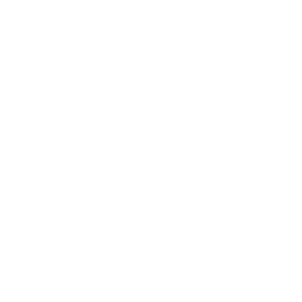

In [33]:
save_path = os.getcwd()
write_all_output(curved_linkage, io.SUBDIVISION_RESOLUTION, io.MODEL_NAME, io.RIBBON_NAME, False, 100, min(io.RIBBON_CS), target_width = 5, flip_angles = False)
os.chdir(save_path)